This code is available on github: https://github.com/WISEPLAT/1-Trading-robot-based-on-computer-vision 

This code is available on kaggle: https://www.kaggle.com/code/olegshpagin/1-trading-robot-based-on-computer-vision

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

import datetime
from psutil import Process
from IPython.display import display_html 

import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator, FixedLocator

from PIL import Image, ImageDraw

pd.options.display.max_columns = None
pd.options.display.max_rows = None
pd.options.display.width = None
pd.set_option('display.max_rows', 100)
pd.set_option('display.min_rows', 20)

# #1 Trading robot based on computer vision

## If you liked this - then say about it)) **⬆️** or **comment** or 🌟

## About

#### A trading robot using neural networks based on computer vision to search for certain formations on a stock trading chart with backtest strategy on history data
* In this notebook, I used trade data from [US stock market dataset](https://www.kaggle.com/datasets/olegshpagin/usa-stocks-prices-ohlcv) for Apple, Amazon, Microsoft, Nvidia, Tesla and Google
* To visualize I'm using Seaborn and Matplotlib
* 2D convolution layer (Conv2d) is used to find formations of stock prices to predict it's future move

# Config

#### Let's get daily and weekly prices OHLCV for Apple, Amazon, Microsoft, Nvidia, Tesla and Google

In [2]:
# you can change config here)))
tickers = ["AAPL.US", "AMZN.US", "MSFT.US", "NVDA.US", "TSLA.US", "GOOGL.US", ]
names = ["Apple", "Amazon", "Microsoft", "Nvidia", "Tesla", "Google"]

timeframe_in = "D1"  # timeframe for neural network training - input and we will trade on the same timeframe
timeframe_out = "W1"  # timeframe for neural network training - output - predicted value

# parameters for drawing images
period_sma_slow = 64 # period of slow SMA
period_sma_fast = 16 # period of fast SMA
draw_window = 128 # data window
steps_skip = 16 # step shift of the data window
draw_size = 128 # side size of the square picture

# Get data

#### Get historical data for strategy and neural network

In [3]:
# Do it for all shares
df_all_in = {}
df_all_out = {}
for ticker in tickers:
    df_all_in[ticker] = pd.read_csv(f"/kaggle/input/usa-stocks-prices-ohlcv/{timeframe_in}/{ticker}_{timeframe_in}.csv", parse_dates=['datetime'])
    df_all_out[ticker] = pd.read_csv(f"/kaggle/input/usa-stocks-prices-ohlcv/{timeframe_out}/{ticker}_{timeframe_out}.csv", parse_dates=['datetime'])

# Check data

#### let's see daily D1 and weekly W1 market data for Apple in Side by Side

#### P.S. If you copy|edit this notebook, then you see these two dataframes in side by side

In [4]:
def show_dfs_in_side_by_side(dfs, captions):
    _disp_dfs = []
    for i in range(len(dfs)):
        _df = dfs[i]
        _caption = captions[i]
        _df_styler = _df.style.set_table_attributes("style='display:inline'").set_caption(_caption)
        _disp_dfs.append(_df_styler._repr_html_())
    display_html(_disp_dfs, raw=True)

In [5]:
show_N_values = 25  # None - for all
show_dfs_in_side_by_side(dfs=[df_all_in["AAPL.US"][:show_N_values], df_all_out["AAPL.US"][:show_N_values]], captions=["Apple daily D1", "Apple weekly W1"])
# P.S. If you copy|edit this notebook, then you see these three dataframes in side by side 

,datetime,open,high,low,close,volume
0,1998-01-02 00:00:00,0.120000,0.140000,0.120000,0.140000,170539824
1,1998-01-05 00:00:00,0.140000,0.140000,0.130000,0.140000,152723900
2,1998-01-06 00:00:00,0.140000,0.170000,0.130000,0.160000,433041952
3,1998-01-07 00:00:00,0.160000,0.160000,0.150000,0.150000,251914152
4,1998-01-08 00:00:00,0.150000,0.160000,0.150000,0.160000,188994988
5,1998-01-09 00:00:00,0.160000,0.170000,0.150000,0.160000,214486244
6,1998-01-12 00:00:00,0.150000,0.160000,0.150000,0.160000,125714764
7,1998-01-13 00:00:00,0.160000,0.170000,0.160000,0.170000,152129936
8,1998-01-14 00:00:00,0.170000,0.170000,0.170000,0.170000,138278308
9,1998-01-15 00:00:00,0.160000,0.170000,0.160000,0.160000,130645452


# Create images

#### Prepare dataset images from historical data

/tmp/ipykernel_19/499069728.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_out.loc[len(df_out.index)] = [df_out_last_date, np.nan ]  #add row to end of DataFrame
/tmp/ipykernel_19/499069728.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_out['close'] = df_out['close'].shift(1)  # let's predict as a target future week, so we need shift down column "close"
/tmp/ipykernel_19/499069728.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

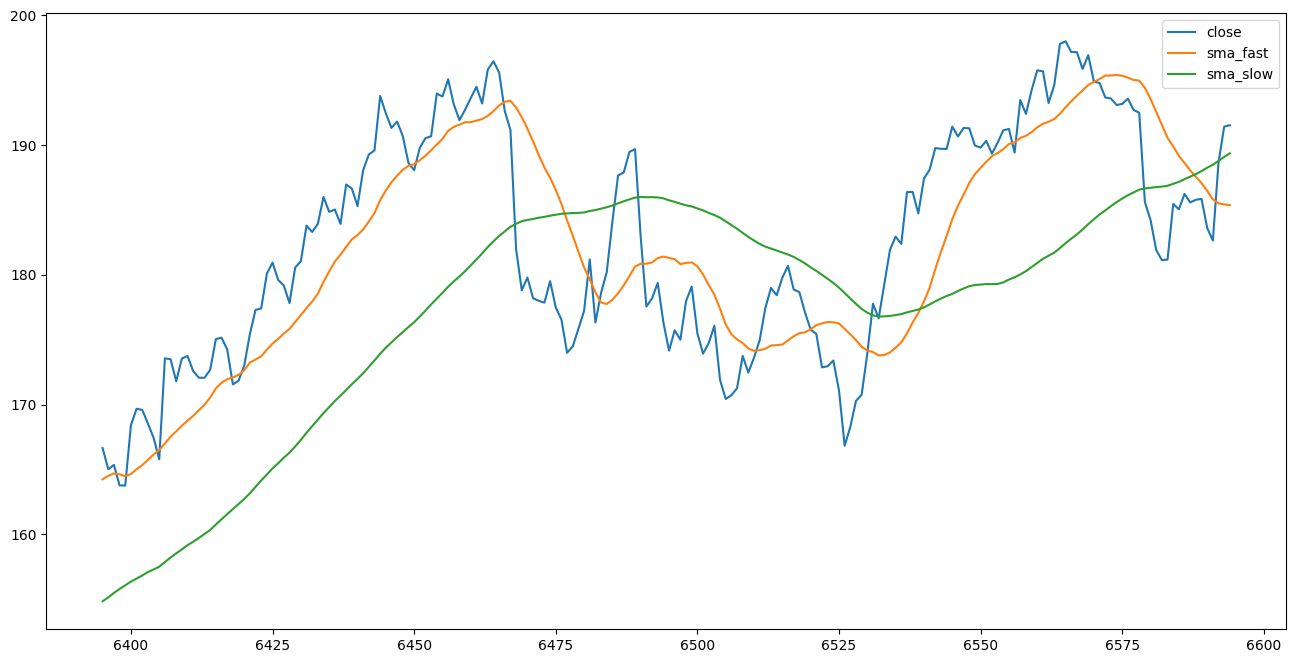

,datetime,open,high,low,close,volume,sma_fast,sma_slow,target,target_datetime,target_pc,target_class
0,1998-01-02 00:00:00,0.120000,0.140000,0.120000,0.140000,170539824,nan,nan,0.140000,1998-01-04 00:00:00,nan,0
1,1998-01-05 00:00:00,0.140000,0.140000,0.130000,0.140000,152723900,nan,nan,0.160000,1998-01-11 00:00:00,0.142857,1
2,1998-01-06 00:00:00,0.140000,0.170000,0.130000,0.160000,433041952,nan,nan,0.160000,1998-01-11 00:00:00,0.142857,1
3,1998-01-07 00:00:00,0.160000,0.160000,0.150000,0.150000,251914152,nan,nan,0.160000,1998-01-11 00:00:00,0.142857,1
4,1998-01-08 00:00:00,0.150000,0.160000,0.150000,0.160000,188994988,nan,nan,0.160000,1998-01-11 00:00:00,0.142857,1
5,1998-01-09 00:00:00,0.160000,0.170000,0.150000,0.160000,214486244,nan,nan,0.160000,1998-01-11 00:00:00,0.142857,1
6,1998-01-12 00:00:00,0.150000,0.160000,0.150000,0.160000,125714764,nan,nan,0.160000,1998-01-18 00:00:00,0.000000,1
7,1998-01-13 00:00:00,0.160000,0.170000,0.160000,0.170000,152129936,nan,nan,0.160000,1998-01-18 00:00:00,0.000000,1
8,1998-01-14 00:00:00,0.170000,0.170000,0.170000,0.170000,138278308,nan,nan,0.160000,1998-01-18 00:00:00,0.000000,1
9,1998-01-15 00:00:00,0.160000,0.170000,0.160000,0.160000,130645452,nan,nan,0.160000,1998-01-18 00:00:00,0.000000,1


,datetime,open,high,low,close,volume,sma_fast,sma_slow,target,target_datetime,target_pc,target_class
6570,2023-12-20 00:00:00,196.940000,197.680000,194.900000,194.910000,29788975,194.877500,184.290469,193.600000,2023-12-24 00:00:00,-0.018106,0
6571,2023-12-21 00:00:00,194.910000,197.080000,193.500000,194.790000,30439350,195.098750,184.658125,193.600000,2023-12-24 00:00:00,-0.018106,0
6572,2023-12-22 00:00:00,194.790000,195.410000,192.970000,193.680000,30025891,195.364375,184.969531,193.600000,2023-12-24 00:00:00,-0.018106,0
6573,2023-12-23 00:00:00,193.690000,193.690000,193.530000,193.600000,4577635,195.371875,185.299688,193.600000,2023-12-24 00:00:00,-0.018106,0
6574,2023-12-26 00:00:00,193.610000,193.890000,192.830000,193.100000,19406020,195.415000,185.603906,193.590000,2023-12-31 00:00:00,-0.000052,0
6575,2023-12-27 00:00:00,193.100000,193.500000,191.090000,193.180000,30641555,195.349375,185.888438,193.590000,2023-12-31 00:00:00,-0.000052,0
6576,2023-12-28 00:00:00,193.190000,194.660000,193.080000,193.590000,22159316,195.213125,186.140625,193.590000,2023-12-31 00:00:00,-0.000052,0
6577,2023-12-29 00:00:00,193.590000,194.400000,191.730000,192.720000,23601216,195.026875,186.355000,193.590000,2023-12-31 00:00:00,-0.000052,0
6578,2023-12-30 00:00:00,192.710000,192.720000,192.490000,192.500000,122214,194.980000,186.574844,193.590000,2023-12-31 00:00:00,-0.000052,0
6579,2024-01-02 00:00:00,187.150000,188.440000,183.890000,185.610000,51717778,194.416250,186.665781,180.370000,2024-01-07 00:00:00,-0.068289,0


In [6]:
show_it_only_once = True
df_in = pd.DataFrame()
df_out = pd.DataFrame()

# Do it for all shares
for ticker in tickers:    
    df_in = df_all_in[ticker]  # get df for ticker - input
    df_in['sma_fast'] = df_in['close'].rolling(period_sma_fast).mean()  # add SMA fast
    df_in['sma_slow'] = df_in['close'].rolling(period_sma_slow).mean()  # add SMA slow
#     df_in.dropna(inplace=True)  # drop all NULL values
    
    _date_in = df_in["datetime"].tolist()
    _close_in = df_in["close"].tolist()
    sma_fast = df_in["sma_fast"].tolist()
    sma_slow = df_in["sma_slow"].tolist()
    
    df_out = df_all_out[ticker]  # get df for ticker - output    
    df_out = df_out[["datetime", "close"]]
    df_out_last_date = df_out["datetime"].iloc[-1]
    df_out_last_date = df_out_last_date + datetime.timedelta(days=7)  # for weekly +7 days - if you will use another tf - so change this delta here too
    df_out.loc[len(df_out.index)] = [df_out_last_date, np.nan ]  #add row to end of DataFrame
    df_out['close'] = df_out['close'].shift(1)  # let's predict as a target future week, so we need shift down column "close"
    df_out['pc'] = df_out['close'].pct_change()  # percent change
#     df_out.dropna(inplace=True)  # drop all NULL values
        
    # join features and target by datetime and two timeframes D1, W1
    packed_w1 = list(zip(df_out.datetime, df_out.close))
    df_in['target'] = [[_close_w1 for _date_w1, _close_w1 in packed_w1 if _date_d1 < _date_w1] for _date_d1 in df_in["datetime"]]  # < - as W1 is formed on next working day - so not <=    
    df_in['target'] = [el[0] if len(el) else np.nan for el in df_in["target"]]
    df_in['target_datetime'] = [[_date_w1 for _date_w1, _close_w1 in packed_w1 if _date_d1 < _date_w1] for _date_d1 in df_in["datetime"]]  # < - as W1 is formed on next working day - so not <=
    df_in['target_datetime'] = [el[0] if len(el) else np.nan for el in df_in["target_datetime"]]
    
    packed_w1 = list(zip(df_out.datetime, df_out.close, df_out.pc))
    df_in['target_pc'] = [[_pc for _date_w1, _close_w1, _pc in packed_w1 if _date_d1 < _date_w1] for _date_d1 in df_in["datetime"]]  # < - as W1 is formed on next working day - so not <=
    df_in['target_pc'] = [el[0] if len(el) else np.nan for el in df_in["target_pc"]]
    
    df_in['target_class'] = [1 if el>=0 else 0 for el in df_in["target_pc"]]  # class: 1 - up, 0 - down

    # displaying the last 200 values for Close + SMA chart
    if show_it_only_once:
        df_in[['close', 'sma_fast', 'sma_slow']].iloc[-200:].plot(label='df', figsize=(16, 8))
        plt.show()
        show_it_only_once = False

    # for debug only - comment it
    show_dfs_in_side_by_side(dfs=[df_in[:show_N_values], df_out[:show_N_values]], captions=["df_in D1", "df_out W1"])  # show first show_N_values
    show_dfs_in_side_by_side(dfs=[df_in[len(df_in)-show_N_values:], df_out[len(df_out)-show_N_values:]], captions=["df_in D1", "df_out W1"])  # show last show_N_values
    # P.S. If you copy|edit this notebook, then you see these three dataframes in side by side 
    break

# Data Leak

#### You can see we have data leak here

![date leak apple](https://github.com/WISEPLAT/imgs_for_repos/blob/master/k/data_leak_apple.jpg?raw=true)

# Remove Data Leak

#### Let's exclude every last row from D1 which one is forming our closing price for W1 (underlined in image)

In [7]:
df_in

,datetime,open,high,low,close,volume,sma_fast,sma_slow,target,target_datetime,target_pc,target_class
0,1998-01-02,0.12,0.14,0.12,0.14,170539824,NaN,NaN,0.14,1998-01-04,NaN,0
1,1998-01-05,0.14,0.14,0.13,0.14,152723900,NaN,NaN,0.16,1998-01-11,0.142857,1
2,1998-01-06,0.14,0.17,0.13,0.16,433041952,NaN,NaN,0.16,1998-01-11,0.142857,1
3,1998-01-07,0.16,0.16,0.15,0.15,251914152,NaN,NaN,0.16,1998-01-11,0.142857,1
4,1998-01-08,0.15,0.16,0.15,0.16,188994988,NaN,NaN,0.16,1998-01-11,0.142857,1
5,1998-01-09,0.16,0.17,0.15,0.16,214486244,NaN,NaN,0.16,1998-01-11,0.142857,1
6,1998-01-12,0.15,0.16,0.15,0.16,125714764,NaN,NaN,0.16,1998-01-18,0.000000,1
7,1998-01-13,0.16,0.17,0.16,0.17,152129936,NaN,NaN,0.16,1998-01-18,0.000000,1
8,1998-01-14,0.17,0.17,0.17,0.17,138278308,NaN,NaN,0.16,1998-01-18,0.000000,1
9,1998-01-15,0.16,0.17,0.16,0.16,130645452,NaN,NaN,0.16,1998-01-18,0.000000,1


In [8]:
df_indexes_to_del = [i for i in range(len(df_in)-1) if df_in["target"].loc[i] == df_in["close"].loc[i] and df_in["target"].loc[i] != df_in["target"].loc[i+1]]
print(df_indexes_to_del, "len:", len(df_indexes_to_del))
df_in = df_in.drop(df_indexes_to_del, axis=0)

[0, 10, 14, 24, 33, 43, 48, 53, 63, 67, 77, 82, 87, 92, 97, 106, 111, 116, 125, 130, 135, 145, 150, 155, 160, 165, 170, 174, 179, 184, 194, 199, 204, 214, 228, 233, 238, 243, 247, 251, 256, 261, 265, 270, 275, 284, 289, 309, 318, 323, 328, 333, 338, 353, 357, 362, 367, 372, 377, 381, 391, 396, 401, 406, 411, 416, 421, 425, 430, 435, 440, 445, 450, 455, 460, 465, 470, 475, 479, 484, 489, 494, 498, 503, 508, 513, 517, 522, 527, 532, 537, 541, 546, 556, 561, 566, 571, 576, 580, 585, 590, 595, 600, 605, 609, 614, 619, 624, 629, 633, 638, 643, 648, 653, 658, 663, 668, 673, 677, 682, 687, 692, 702, 707, 712, 717, 722, 727, 731, 736, 741, 746, 755, 759, 764, 773, 778, 783, 792, 797, 802, 807, 812, 817, 822, 826, 831, 836, 841, 846, 851, 856, 860, 865, 870, 875, 880, 884, 889, 894, 899, 904, 909, 914, 924, 928, 929, 939, 944, 954, 974, 978, 983, 988, 993, 998, 1002, 1006, 1011, 1016, 1020, 1025, 1035, 1039, 1044, 1054, 1059, 1063, 1078, 1093, 1098, 1103, 1107, 1112, 1117, 1122, 1127, 1131, 113

#### More info about Data Leak here: https://www.kaggle.com/code/olegshpagin/1-predict-amazon-prepare-dataframe-to-train-nn how to find and remove it

#### Just another data leak where is price on next day are the same... but it is Friday... Let's remove this too.

In [9]:
df_in = df_in.reset_index(drop=True)

In [10]:
df_indexes_to_del = [i for i in range(len(df_in)-1) if df_in["target"].loc[i] == df_in["close"].loc[i] and df_in["datetime"].loc[i].strftime("%A") == "Friday"]
print(df_indexes_to_del, "len:", len(df_indexes_to_del))
df_in = df_in.drop(df_indexes_to_del, axis=0)

[4, 16, 25, 33, 50, 62, 86, 103, 119, 159, 176, 185, 190, 235, 247, 252, 257, 290, 295, 326, 458, 575, 619, 633, 650, 755, 767, 780, 789, 794, 799, 848, 864, 880, 885, 894, 899, 946, 970, 979, 988, 993, 1010, 1015, 1027, 1036, 1043, 1059, 1068, 1072, 1085, 1094, 1103, 1170, 1210, 1215, 1235, 1240, 1252, 1264, 1268, 1273, 1309, 1333, 1402, 1411, 1470, 1520, 1591, 1973, 2162, 2217, 2267, 2656, 2901, 3988, 4886, 5083, 5125, 5195] len: 80


In [11]:
df_in = df_in.reset_index(drop=True)
df_in

,datetime,open,high,low,close,volume,sma_fast,sma_slow,target,target_datetime,target_pc,target_class
0,1998-01-05,0.14,0.14,0.13,0.14,152723900,NaN,NaN,0.16,1998-01-11,0.142857,1
1,1998-01-06,0.14,0.17,0.13,0.16,433041952,NaN,NaN,0.16,1998-01-11,0.142857,1
2,1998-01-07,0.16,0.16,0.15,0.15,251914152,NaN,NaN,0.16,1998-01-11,0.142857,1
3,1998-01-08,0.15,0.16,0.15,0.16,188994988,NaN,NaN,0.16,1998-01-11,0.142857,1
4,1998-01-12,0.15,0.16,0.15,0.16,125714764,NaN,NaN,0.16,1998-01-18,0.000000,1
5,1998-01-13,0.16,0.17,0.16,0.17,152129936,NaN,NaN,0.16,1998-01-18,0.000000,1
6,1998-01-14,0.17,0.17,0.17,0.17,138278308,NaN,NaN,0.16,1998-01-18,0.000000,1
7,1998-01-15,0.16,0.17,0.16,0.16,130645452,NaN,NaN,0.16,1998-01-18,0.000000,1
8,1998-01-20,0.16,0.17,0.16,0.16,58293284,NaN,NaN,0.17,1998-01-25,0.062500,1
9,1998-01-21,0.16,0.16,0.16,0.16,45488800,NaN,NaN,0.17,1998-01-25,0.062500,1


# Prepare dataset images

#### Recreate our code to prevent Data Leak

In [12]:
# to remove SettingWithCopyWarning
pd.options.mode.chained_assignment = None  # default='warn'

In [13]:
def show_img(n):
    try:
        n = int(n)
        img_list = os.listdir(train_images / all_folders[n])
        num_images = len(img_list)
        print(num_images)
        if(num_images<=10):
            fig,ax = plt.subplots(2,5, figsize=(20,10))
            print(ax.shape)
            for i in range(len(img_list)):
                with open(train_images / all_folders[n] / img_list[i] ,'rb') as f:
                    img = Image.open(f)
                    ax[i//5][i%5].imshow(img)
            fig.show()

        else:
            fig,ax = plt.subplots((-(-num_images//10)),10, figsize=(40,10))
            print(ax.shape)
            for i in range(len(img_list)):
                with open(train_images / all_folders[n] / img_list[i] ,'rb') as f:
                    img = Image.open(f)
                    ax[i//10][i%10].imshow(img)
            fig.show()
    except ValueError:
        n = all_folders.index(n)
        img_list = os.listdir(train_images / all_folders[n])
        num_images = len(img_list)
        print(num_images)
        if(num_images<=10):
            fig,ax = plt.subplots(2,5, figsize=(20,10))
            print(ax.shape)
            for i in range(len(img_list)):
                with open(train_images / all_folders[n] / img_list[i] ,'rb') as f:
                    img = Image.open(f)
                    ax[i//5][i%5].imshow(img)
            fig.show()

        else:
            fig,ax = plt.subplots((-(-num_images//10)),10, figsize=(40,10))
            print(ax.shape)
            for i in range(len(img_list)):
                with open(train_images / all_folders[n] / img_list[i] ,'rb') as f:
                    img = Image.open(f)
                    ax[i//10][i%10].imshow(img)
            fig.show()

In [14]:
def generate_img(_sma_fast_list, _sma_slow_list, _closes_list, draw_window):
    """Image generation for neural network training/test"""
    _max = max(max(_sma_fast_list), max(_sma_slow_list), max(_closes_list))
    _min = min(min(_sma_fast_list), min(_sma_slow_list), min(_closes_list))
    _delta_h = _max - _min
    _k_h = (draw_window - 1) / _delta_h  # scaling factor by _h for squaring
    w, h = draw_window, draw_window

    # creating new Image object - https://www.geeksforgeeks.org/python-pil-imagedraw-draw-line/
    img = Image.new("RGB", (w, h))
    img1 = ImageDraw.Draw(img)
    for i in range(1, w):
        # print(_sma_fast_list[i], _sma_slow_list[i])
        # we will use lines to scale - or we can use dots
        # ploting price
        _h_1 = int((_closes_list[i - 1] - _min) * _k_h)
        _h = int((_closes_list[i] - _min) * _k_h)
        shape = [(i - 1, _h_1), (i, _h)]
        img1.line(shape, fill="red", width=0)
        # plotting fast SMA
        _h_1 = int((_sma_fast_list[i - 1] - _min) * _k_h)
        _h = int((_sma_fast_list[i] - _min) * _k_h)
        shape = [(i - 1, _h_1), (i, _h)]
        img1.line(shape, fill="blue", width=0)
        # plotting slow SMA
        _h_1 = int((_sma_slow_list[i - 1] - _min) * _k_h)
        _h = int((_sma_slow_list[i] - _min) * _k_h)
        shape = [(i - 1, _h_1), (i, _h)]
        img1.line(shape, fill="green", width=0)
    return img

In [15]:
# create folders for images
folder_NN_timeframe = None
folder = 'NN'
if not os.path.exists(folder): os.makedirs(folder)
for timeframe in [timeframe_in, ]:  # timeframe_out
    _folder = os.path.join(folder, f"training_dataset_{timeframe}")
    folder_NN_timeframe = _folder
    if not os.path.exists(_folder): os.makedirs(_folder)
    for _class in [0, 1]:
        _folder_class = os.path.join(_folder, f"{_class}")
        if not os.path.exists(_folder_class): os.makedirs(_folder_class)

{'AAPL.US': True, 'AMZN.US': True, 'MSFT.US': True, 'NVDA.US': True, 'TSLA.US': True, 'GOOGL.US': True}


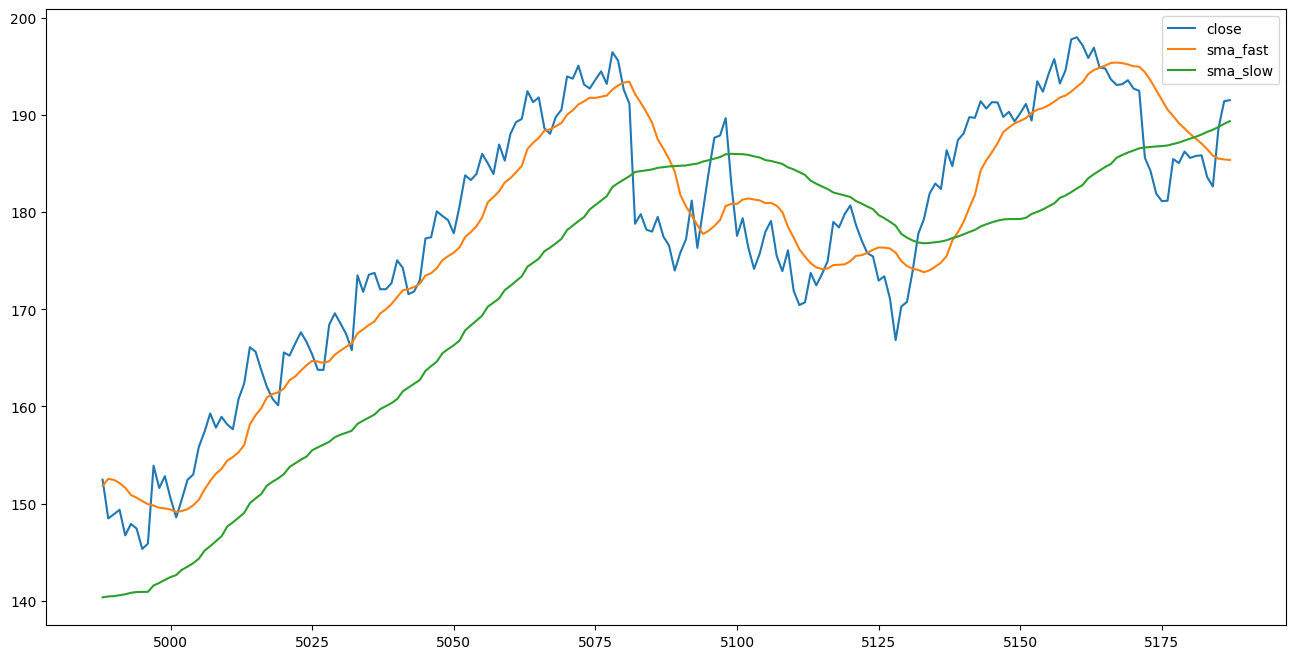

,datetime,open,high,low,close,volume,sma_fast,sma_slow,target,target_datetime,target_pc,target_class
0,1998-04-06 00:00:00,0.240000,0.240000,0.230000,0.230000,74466112,0.235625,0.191719,0.220000,1998-04-12 00:00:00,-0.083333,0
1,1998-04-07 00:00:00,0.220000,0.230000,0.220000,0.220000,65498104,0.235000,0.192969,0.220000,1998-04-12 00:00:00,-0.083333,0
2,1998-04-08 00:00:00,0.220000,0.220000,0.220000,0.220000,54771024,0.234375,0.193906,0.220000,1998-04-12 00:00:00,-0.083333,0
3,1998-04-13 00:00:00,0.220000,0.230000,0.220000,0.230000,69322708,0.233125,0.196094,0.240000,1998-04-19 00:00:00,0.090909,1
4,1998-04-14 00:00:00,0.230000,0.240000,0.230000,0.240000,80388336,0.233750,0.197344,0.240000,1998-04-19 00:00:00,0.090909,1
5,1998-04-15 00:00:00,0.240000,0.240000,0.230000,0.240000,135811732,0.234375,0.198594,0.240000,1998-04-19 00:00:00,0.090909,1
6,1998-04-16 00:00:00,0.250000,0.260000,0.250000,0.250000,419517756,0.235000,0.199844,0.240000,1998-04-19 00:00:00,0.090909,1
7,1998-04-20 00:00:00,0.240000,0.260000,0.240000,0.250000,125132616,0.236250,0.202344,0.240000,1998-04-26 00:00:00,0.000000,1
8,1998-04-21 00:00:00,0.250000,0.250000,0.250000,0.250000,83123740,0.236875,0.203750,0.240000,1998-04-26 00:00:00,0.000000,1
9,1998-04-22 00:00:00,0.250000,0.250000,0.240000,0.240000,66309852,0.236875,0.205000,0.240000,1998-04-26 00:00:00,0.000000,1


,datetime,open,high,low,close,volume,sma_fast,sma_slow,target,target_datetime,target_pc,target_class
5163,2023-12-19 00:00:00,195.890000,196.950000,195.880000,196.940000,21987940,194.642500,183.912500,193.600000,2023-12-24 00:00:00,-0.018106,0
5164,2023-12-20 00:00:00,196.940000,197.680000,194.900000,194.910000,29788975,194.877500,184.290469,193.600000,2023-12-24 00:00:00,-0.018106,0
5165,2023-12-21 00:00:00,194.910000,197.080000,193.500000,194.790000,30439350,195.098750,184.658125,193.600000,2023-12-24 00:00:00,-0.018106,0
5166,2023-12-22 00:00:00,194.790000,195.410000,192.970000,193.680000,30025891,195.364375,184.969531,193.600000,2023-12-24 00:00:00,-0.018106,0
5167,2023-12-26 00:00:00,193.610000,193.890000,192.830000,193.100000,19406020,195.415000,185.603906,193.590000,2023-12-31 00:00:00,-0.000052,0
5168,2023-12-27 00:00:00,193.100000,193.500000,191.090000,193.180000,30641555,195.349375,185.888438,193.590000,2023-12-31 00:00:00,-0.000052,0
5169,2023-12-28 00:00:00,193.190000,194.660000,193.080000,193.590000,22159316,195.213125,186.140625,193.590000,2023-12-31 00:00:00,-0.000052,0
5170,2023-12-29 00:00:00,193.590000,194.400000,191.730000,192.720000,23601216,195.026875,186.355000,193.590000,2023-12-31 00:00:00,-0.000052,0
5171,2023-12-30 00:00:00,192.710000,192.720000,192.490000,192.500000,122214,194.980000,186.574844,193.590000,2023-12-31 00:00:00,-0.000052,0
5172,2024-01-02 00:00:00,187.150000,188.440000,183.890000,185.610000,51717778,194.416250,186.665781,180.370000,2024-01-07 00:00:00,-0.068289,0


AAPL.US 1998-11-19 00:00:00


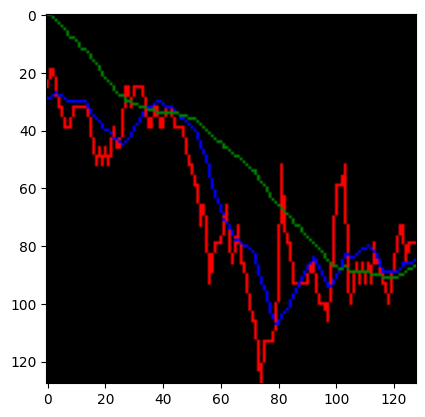

AMZN.US 1998-11-19 00:00:00


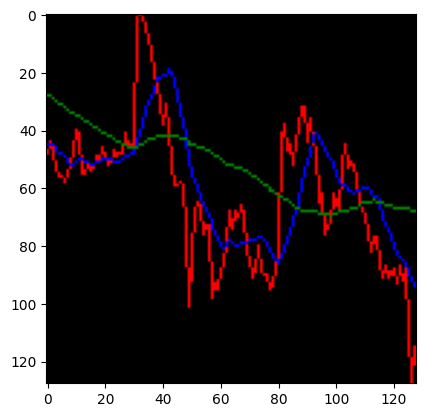

MSFT.US 1998-11-19 00:00:00


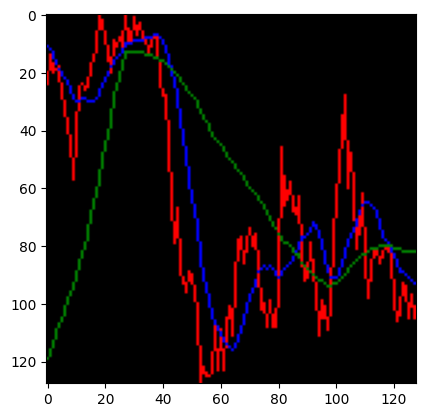

NVDA.US 1999-12-09 00:00:00


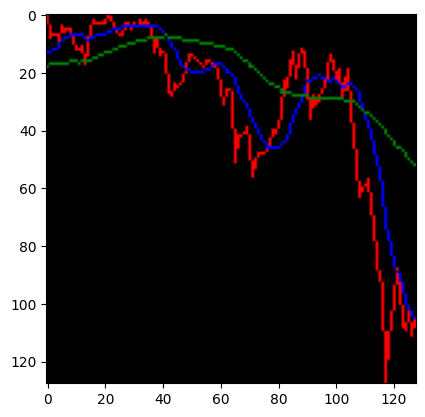

TSLA.US 2011-05-17 00:00:00


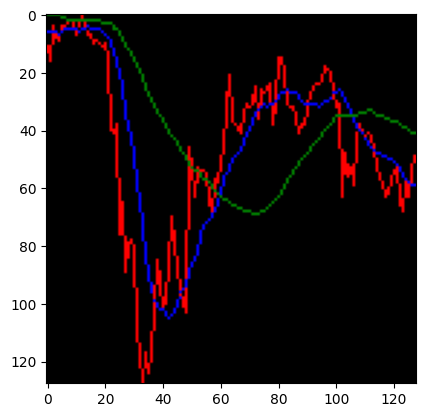

GOOGL.US 2005-07-11 00:00:00


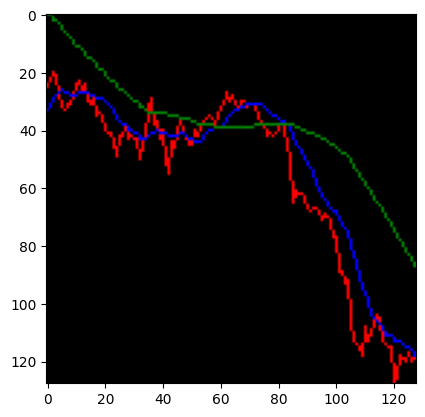

In [16]:
show_it_only_once = True
show_it_only_per_ticker = {ticker: True for ticker in tickers}
print(show_it_only_per_ticker)
df_in = pd.DataFrame()
df_out = pd.DataFrame()

# Do it for all shares
for ticker in tickers:    
    df_in = df_all_in[ticker]  # get df for ticker - input
    df_in['sma_fast'] = df_in['close'].rolling(period_sma_fast).mean()  # add SMA fast
    df_in['sma_slow'] = df_in['close'].rolling(period_sma_slow).mean()  # add SMA slow
    df_in.dropna(inplace=True)  # drop all NULL values
    df_in = df_in.reset_index(drop=True)
        
    df_out = df_all_out[ticker]  # get df for ticker - output    
    df_out = df_out[["datetime", "close"]]
    df_out_last_date = df_out["datetime"].iloc[-1]
    df_out_last_date = df_out_last_date + datetime.timedelta(days=7)  # for weekly +7 days - if you will use another tf - so change this delta here too
    df_out.loc[len(df_out.index)] = [df_out_last_date, np.nan ]  #add row to end of DataFrame
    df_out['close'] = df_out['close'].shift(1)  # let's predict as a target future week, so we need shift down column "close"
    df_out['pc'] = df_out['close'].pct_change()  # percent change
    df_out = df_out.reset_index(drop=True)
    df_out.dropna(inplace=True)  # drop all NULL values
    df_out = df_out.reset_index(drop=True)    
        
    # join features and target by datetime and two timeframes D1, W1
    packed_w1 = list(zip(df_out.datetime, df_out.close))
    df_in['target'] = [[_close_w1 for _date_w1, _close_w1 in packed_w1 if _date_d1 < _date_w1] for _date_d1 in df_in["datetime"]]  # < - as W1 is formed on next working day - so not <=    
    df_in['target'] = [el[0] if len(el) else np.nan for el in df_in["target"]]
    df_in['target_datetime'] = [[_date_w1 for _date_w1, _close_w1 in packed_w1 if _date_d1 < _date_w1] for _date_d1 in df_in["datetime"]]  # < - as W1 is formed on next working day - so not <=
    df_in['target_datetime'] = [el[0] if len(el) else np.nan for el in df_in["target_datetime"]]
    
    packed_w1 = list(zip(df_out.datetime, df_out.close, df_out.pc))
    df_in['target_pc'] = [[_pc for _date_w1, _close_w1, _pc in packed_w1 if _date_d1 < _date_w1] for _date_d1 in df_in["datetime"]]  # < - as W1 is formed on next working day - so not <=
    df_in['target_pc'] = [el[0] if len(el) else np.nan for el in df_in["target_pc"]]
    df_in['target_class'] = [1 if el>=0 else 0 for el in df_in["target_pc"]]  # class: 1 - up, 0 - down
    
    # remove Data Leak - 1
    df_indexes_to_del = [i for i in range(len(df_in)-1) if df_in["target"].loc[i] == df_in["close"].loc[i] and df_in["target"].loc[i] != df_in["target"].loc[i+1]]
    df_in = df_in.drop(df_indexes_to_del, axis=0)
    df_in = df_in.reset_index(drop=True)
    
    # remove Data Leak - 2
    df_indexes_to_del = [i for i in range(len(df_in)-1) if df_in["target"].loc[i] == df_in["close"].loc[i] and df_in["datetime"].loc[i].strftime("%A") == "Friday"]
    df_in = df_in.drop(df_indexes_to_del, axis=0)
    df_in = df_in.reset_index(drop=True)
    
    # take variables after removing data leak and droping Nan
    _date_in = df_in["datetime"].tolist()
    _close_in = df_in["close"].tolist()
    sma_fast = df_in["sma_fast"].tolist()
    sma_slow = df_in["sma_slow"].tolist()
    
    # displaying the last 200 values for Close + SMA chart
    if show_it_only_once:
        df_in[['close', 'sma_fast', 'sma_slow']].iloc[-200:].plot(label='df', figsize=(16, 8))
        plt.show()
        show_it_only_once = False

        # for debug only - comment it
        show_dfs_in_side_by_side(dfs=[df_in[:show_N_values], df_out[:show_N_values]], captions=["df_in D1", "df_out W1"])  # show first show_N_values
        show_dfs_in_side_by_side(dfs=[df_in[len(df_in)-show_N_values:], df_out[len(df_out)-show_N_values:]], captions=["df_in D1", "df_out W1"])  # show last show_N_values
        # P.S. If you copy|edit this notebook, then you see these three dataframes in side by side 
    
    packed_cols = list(zip(df_in.datetime, df_in.target_class))
    _steps, j = 0, 0
    # draw picture only for smallest timeframe
    for _date, _target_class in packed_cols:
        _steps += 1
        j += 1
        if _steps >= steps_skip and j >= draw_window:
            _steps = 0

            # creating an image for a neural network linked to a date and ticker in increments: steps_skip
            # with size [draw_size, draw_size]
            _sma_fast_list = sma_fast[j-draw_window:j]
            _sma_slow_list = sma_slow[j-draw_window:j]
            _closes_list = _close_in[j-draw_window:j]

            # image generation for neural network training/test
            img = generate_img(_sma_fast_list, _sma_slow_list, _closes_list, draw_window)
#             img.show()  # show the generated image
            if show_it_only_per_ticker[ticker]:  # show once image for every ticker
                print(ticker, _date)
                plt.imshow(img)
                plt.show()
                show_it_only_per_ticker[ticker] = False
            
            _date_str = _date.strftime("%Y_%m_%d_%H_%M_%S")
            _filename = f"{ticker}-{timeframe_in}-{_date_str}.png"
            _path = os.path.join("NN", f"training_dataset_{timeframe_in}")
            
#             break

            # images classification
            # if data.close[0] > data.close[-1]:
            if _target_class:  # close_out[_date_out_index[_date]] > _close_out[_date_out_index[_date]-1]:
                _path = os.path.join(_path, "1")
            else:
                _path = os.path.join(_path, "0")

            img.save(os.path.join(_path, _filename))
#         print(ticker, _date)


#### How many images was generated?

In [17]:
folder_NN_timeframe_class_1 = os.path.join(folder_NN_timeframe, "1")
folder_NN_timeframe_class_0 = os.path.join(folder_NN_timeframe, "0")
onlyfiles_1 = [f for f in os.listdir(folder_NN_timeframe_class_1) if os.path.isfile(os.path.join(folder_NN_timeframe_class_1, f))]
onlyfiles_0 = [f for f in os.listdir(folder_NN_timeframe_class_0) if os.path.isfile(os.path.join(folder_NN_timeframe_class_0, f))]
print("Total images for class 1: ", len(onlyfiles_1), "for class 0: ", len(onlyfiles_0))

Total images for class 1:  914 for class 0:  736


# Train NN

#### In the code below, we are training a neural network, and use data from timeframe_in as input, and data from timeframe_out as output

# Import libraries

In [18]:
import tensorflow as tf
from tensorflow import keras
from tensorflow import config
print("Num GPUs Available: ", len(config.list_physical_devices('GPU')))
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPooling2D, Rescaling
from keras.layers import Activation, Dropout, Flatten, Dense, BatchNormalization
from keras.callbacks import ModelCheckpoint, LambdaCallback

Num GPUs Available:  0


# Config

In [19]:
seed = 777  # to produce similar result in each run - sets value for random seed  # 42++ 77+
data_dir = os.path.join("NN", f"training_dataset_{timeframe_in}")  # folder with data
num_classes = 2  # total classes
epochs = 20  # number of epochs
batch_size = 10  # batch size
img_height, img_width = draw_size, draw_size  # images size
input_shape = (img_height, img_width, 3)  # dimention of image 3 - RGB

# Reproducibility

#### Sets value for random seed to produce similar result in each run

In [20]:
keras.utils.set_random_seed(seed)

# Model

In [21]:
model = Sequential([
        Rescaling(1. / 255),
        Conv2D(32, 3, activation='relu'),
        MaxPooling2D(),
        BatchNormalization(),
        Conv2D(32, 3, activation='relu'),
        MaxPooling2D(),
        BatchNormalization(),
        Conv2D(32, 3, activation='relu'),
        MaxPooling2D(),
        BatchNormalization(),
        Flatten(),
        Dense(128, activation='relu'),
        Dense(num_classes)
    ])

# Compile

In [22]:
# version with Adam optimization is a stochastic gradient descent method
model.compile(
    optimizer='adam',
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'])

# Train data

In [23]:
# Train data
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    # seed=123,
    shuffle=False,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 1650 files belonging to 2 classes.
Using 1320 files for training.


# Check Train data

In [24]:
file_paths_train_ds = train_ds.file_paths
print(file_paths_train_ds)

['NN/training_dataset_D1/0/AAPL.US-D1-1999_01_21_00_00_00.png', 'NN/training_dataset_D1/0/AAPL.US-D1-1999_02_22_00_00_00.png', 'NN/training_dataset_D1/0/AAPL.US-D1-1999_07_14_00_00_00.png', 'NN/training_dataset_D1/0/AAPL.US-D1-1999_12_06_00_00_00.png', 'NN/training_dataset_D1/0/AAPL.US-D1-2000_01_04_00_00_00.png', 'NN/training_dataset_D1/0/AAPL.US-D1-2000_03_30_00_00_00.png', 'NN/training_dataset_D1/0/AAPL.US-D1-2000_05_01_00_00_00.png', 'NN/training_dataset_D1/0/AAPL.US-D1-2000_07_26_00_00_00.png', 'NN/training_dataset_D1/0/AAPL.US-D1-2000_09_21_00_00_00.png', 'NN/training_dataset_D1/0/AAPL.US-D1-2000_10_19_00_00_00.png', 'NN/training_dataset_D1/0/AAPL.US-D1-2000_11_16_00_00_00.png', 'NN/training_dataset_D1/0/AAPL.US-D1-2001_02_15_00_00_00.png', 'NN/training_dataset_D1/0/AAPL.US-D1-2001_06_13_00_00_00.png', 'NN/training_dataset_D1/0/AAPL.US-D1-2001_08_09_00_00_00.png', 'NN/training_dataset_D1/0/AAPL.US-D1-2001_09_17_00_00_00.png', 'NN/training_dataset_D1/0/AAPL.US-D1-2001_12_11_00_00_

In [25]:
class_0, class_1 = 0, 0
for _filename in file_paths_train_ds:
    if _filename.find("/0/") >=0: class_0 += 1
    if _filename.find("/1/") >=0: class_1 += 1
print(f"Train Data - Found class==0 images {class_0}")
print(f"Train Data - Found class==1 images {class_1}")
print(f"Train Data - Total class==1 + Class==0 images {class_1+class_0}")

Train Data - Found class==0 images 736
Train Data - Found class==1 images 584
Train Data - Total class==1 + Class==0 images 1320


so, all images from class==0 we used for train only

PS. Found 1646 files belonging to 2 classes. Using 1317 files for training. == OK for Training dataset!

Total images for class 1:  911 for class 0:  735 => 911+735=1646

#### To test if train_ds has the right number of classes

In [26]:
print(train_ds.class_names)

['0', '1']


# Validation data

In [27]:
# Validation data
val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    # seed=123,
    shuffle=False,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 1650 files belonging to 2 classes.
Using 330 files for validation.


#### Let's create copy for future comparing

In [28]:
val_ds_future = val_ds

In [29]:
file_paths_val_ds = val_ds_future.file_paths
print(file_paths_val_ds)

['NN/training_dataset_D1/1/MSFT.US-D1-2013_12_23_00_00_00.png', 'NN/training_dataset_D1/1/MSFT.US-D1-2014_01_23_00_00_00.png', 'NN/training_dataset_D1/1/MSFT.US-D1-2014_02_24_00_00_00.png', 'NN/training_dataset_D1/1/MSFT.US-D1-2014_03_24_00_00_00.png', 'NN/training_dataset_D1/1/MSFT.US-D1-2014_05_20_00_00_00.png', 'NN/training_dataset_D1/1/MSFT.US-D1-2014_06_18_00_00_00.png', 'NN/training_dataset_D1/1/MSFT.US-D1-2014_07_17_00_00_00.png', 'NN/training_dataset_D1/1/MSFT.US-D1-2014_08_14_00_00_00.png', 'NN/training_dataset_D1/1/MSFT.US-D1-2014_09_15_00_00_00.png', 'NN/training_dataset_D1/1/MSFT.US-D1-2014_11_10_00_00_00.png', 'NN/training_dataset_D1/1/MSFT.US-D1-2015_01_08_00_00_00.png', 'NN/training_dataset_D1/1/MSFT.US-D1-2015_02_09_00_00_00.png', 'NN/training_dataset_D1/1/MSFT.US-D1-2015_04_08_00_00_00.png', 'NN/training_dataset_D1/1/MSFT.US-D1-2015_07_06_00_00_00.png', 'NN/training_dataset_D1/1/MSFT.US-D1-2015_08_03_00_00_00.png', 'NN/training_dataset_D1/1/MSFT.US-D1-2015_09_29_00_00_

# Check Validation data

In [30]:
class_0, class_1 = 0, 0
for _filename in file_paths_val_ds:
    if _filename.find("/0/") >=0: class_0 += 1
    if _filename.find("/1/") >=0: class_1 += 1
print(f"Validation Data - Found class==0 images {class_0}")
print(f"Validation Data - Found class==1 images {class_1}")

Validation Data - Found class==0 images 0
Validation Data - Found class==1 images 330


so only some images from class==1 was used for validation

PS. Found 1646 files belonging to 2 classes. Using 329 files for validation.

Let's check if we have the same data in Train and Validation Data

In [31]:
# some code - in process of writing
elems_in_both_lists = set(file_paths_train_ds) & set(file_paths_val_ds)
print(elems_in_both_lists)

set()


#### To test if val_ds has the right number of classes

In [32]:
print(val_ds.class_names)

['0', '1']


# Why???

#### Why for validation we are using only one class???

# FIX

Replacing categorical for binary in the label_mode it will fix the [problem](https://stackoverflow.com/questions/69773382/validation-set-has-images-from-only-one-class-if-obtained-through-image-dataset).

In [33]:
# Train data
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    labels='inferred',
    label_mode='int',
#     seed=123,
    shuffle=False,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 1650 files belonging to 2 classes.
Using 1320 files for training.


In [34]:
# check train data
file_paths_train_ds = train_ds.file_paths
# print(file_paths_train_ds)
class_0, class_1 = 0, 0
for _filename in file_paths_train_ds:
    if _filename.find("/0/") >=0: class_0 += 1
    if _filename.find("/1/") >=0: class_1 += 1
print(f"Train Data - Found class==0 images {class_0}")
print(f"Train Data - Found class==1 images {class_1}")
print(f"Train Data - Total class==1 + Class==0 images {class_1+class_0}")

Train Data - Found class==0 images 736
Train Data - Found class==1 images 584
Train Data - Total class==1 + Class==0 images 1320


In [35]:
# Validation data
val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    labels='inferred',
    label_mode='int',
#     seed=123,
    shuffle=False,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 1650 files belonging to 2 classes.
Using 330 files for validation.


In [36]:
# check validation data
file_paths_val_ds = val_ds_future.file_paths
# print(file_paths_val_ds)
class_0, class_1 = 0, 0
for _filename in file_paths_val_ds:
    if _filename.find("/0/") >=0: class_0 += 1
    if _filename.find("/1/") >=0: class_1 += 1
print(f"Validation Data - Found class==0 images {class_0}")
print(f"Validation Data - Found class==1 images {class_1}")


Validation Data - Found class==0 images 0
Validation Data - Found class==1 images 330


#### Doesn't help

# Try Fix 2

In [37]:
print(data_dir)

NN/training_dataset_D1


In [38]:
# Train, Validation data
train_ds, val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir+"/",
    validation_split=0.2,
    subset="both",
    # seed=123,
    shuffle=False,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 1650 files belonging to 2 classes.
Using 1320 files for training.
Using 330 files for validation.


In [39]:
# check train data
file_paths_train_ds = train_ds.file_paths
# print(file_paths_train_ds)
class_0, class_1 = 0, 0
for _filename in file_paths_train_ds:
    if _filename.find("/0/") >=0: class_0 += 1
    if _filename.find("/1/") >=0: class_1 += 1
print(f"Train Data - Found class==0 images {class_0}")
print(f"Train Data - Found class==1 images {class_1}")
print(f"Train Data - Total class==1 + Class==0 images {class_1+class_0}")

Train Data - Found class==0 images 736
Train Data - Found class==1 images 584
Train Data - Total class==1 + Class==0 images 1320


In [40]:
# check validation data
file_paths_val_ds = val_ds_future.file_paths
# print(file_paths_val_ds)
class_0, class_1 = 0, 0
for _filename in file_paths_val_ds:
    if _filename.find("/0/") >=0: class_0 += 1
    if _filename.find("/1/") >=0: class_1 += 1
print(f"Validation Data - Found class==0 images {class_0}")
print(f"Validation Data - Found class==1 images {class_1}")

Validation Data - Found class==0 images 0
Validation Data - Found class==1 images 330


#### Doesn't help

#### But here https://www.kaggle.com/olegshpagin/just-to-show-images-load-to-fix/ it is works... How it can be? May be someone has the answer?

# Ooo May be Fix?

#### we see that error in shuffle=False,

## fixed in next version of this notebook

# Let's continue for now...

# Normalization

#### normalization is right in the model

# Callback

In [41]:
# here we will save all our trained models
list_for_models = []

In [42]:
class SaveAllModels(tf.keras.callbacks.Callback):

    def __init__(self, external_list):
        self.list_obj = external_list
    
    def on_epoch_end(self, epoch, logs=None):
        self.list_obj.append({
            "model": self.model,
            "loss": logs['loss'],
            "accuracy": logs['accuracy'],
            "val_loss": logs['val_loss'],
            "val_accuracy": logs['val_accuracy'],
        })

In [43]:
save_all_models_callback = SaveAllModels(list_for_models)

In [44]:
callbacks = [
                save_all_models_callback, # ModelCheckpoint(" 'model_{epoch:1d}.hdf5'"),
            ]

# Run learning

In [45]:
# starting the learning process
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=callbacks
)

Epoch 1/20
132/132 [==============================] - 17s 112ms/step - loss: 0.8661 - accuracy: 0.9326 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 2/20
132/132 [==============================] - 14s 104ms/step - loss: 3.1645 - accuracy: 0.8939 - val_loss: 2.0621e-04 - val_accuracy: 1.0000
Epoch 3/20
132/132 [==============================] - 14s 108ms/step - loss: 3.8252 - accuracy: 0.8386 - val_loss: 0.1299 - val_accuracy: 0.9909
Epoch 4/20
132/132 [==============================] - 14s 109ms/step - loss: 4.7596 - accuracy: 0.7833 - val_loss: 0.1211 - val_accuracy: 0.9909
Epoch 5/20
132/132 [==============================] - 14s 105ms/step - loss: 0.9594 - accuracy: 0.7856 - val_loss: 0.1338 - val_accuracy: 0.9879
Epoch 6/20
132/132 [==============================] - 14s 108ms/step - loss: 0.9702 - accuracy: 0.6136 - val_loss: 0.4479 - val_accuracy: 0.9697
Epoch 7/20
132/132 [==============================] - 14s 106ms/step - loss: 0.6982 - accuracy: 0.5333 - val_loss: 0.6882 

#### just cool log.... 777+
Epoch 16/20
**132/132 [==============================] - 14s 104ms/step - loss: 0.3881 - accuracy: 0.7973 - val_loss: 0.3321 - val_accuracy: 0.9179**

#### just cool log.... 77+
Epoch 16/20
**132/132 [==============================] - 14s 108ms/step - loss: 0.4548 - accuracy: 0.7046 - val_loss: 0.5889 - val_accuracy: 0.8784**

#### just cool log.... 44++
Epoch 1/20
132/132 [==============================] - 15s 101ms/step - loss: 0.7742 - accuracy: 0.9370 - val_loss: 4.3481e-09 - val_accuracy: 1.0000

Epoch 2/20
132/132 [==============================] - 13s 97ms/step - loss: 3.2420 - accuracy: 0.8929 - val_loss: 0.0027 - val_accuracy: 1.0000

Epoch 3/20
132/132 [==============================] - 13s 99ms/step - loss: 2.7216 - accuracy: 0.8626 - val_loss: 0.0036 - val_accuracy: 1.0000

Epoch 4/20
132/132 [==============================] - 13s 95ms/step - loss: 6.3131 - accuracy: 0.7912 - val_loss: 0.1130 - val_accuracy: 0.9939

Epoch 5/20
132/132 [==============================] - 13s 95ms/step - loss: 2.5657 - accuracy: 0.7920 - val_loss: 0.0143 - val_accuracy: 1.0000

Epoch 6/20
132/132 [==============================] - 13s 97ms/step - loss: 0.8638 - accuracy: 0.7312 - val_loss: 0.2701 - val_accuracy: 0.9787

Epoch 7/20
132/132 [==============================] - 12s 94ms/step - loss: 0.7324 - accuracy: 0.5057 - val_loss: 0.4755 - val_accuracy: 0.9483

Epoch 8/20
132/132 [==============================] - 13s 98ms/step - loss: 0.6753 - accuracy: 0.4579 - val_loss: 0.7063 - val_accuracy: 0.8237

Epoch 9/20
132/132 [==============================] - 14s 103ms/step - loss: 0.6117 - accuracy: 0.5596 - val_loss: 0.6542 - val_accuracy: 0.5502

Epoch 10/20
132/132 [==============================] - 11s 86ms/step - loss: 0.5736 - accuracy: 0.6515 - val_loss: 0.6791 - val_accuracy: 0.5653

Epoch 11/20
132/132 [==============================] - 10s 77ms/step - loss: 0.5255 - accuracy: 0.7411 - val_loss: 0.3816 - val_accuracy: 0.8967

Epoch 12/20
132/132 [==============================] - 10s 75ms/step - loss: 0.5034 - accuracy: 0.6879 - val_loss: 0.6553 - val_accuracy: 0.7325

Epoch 13/20
132/132 [==============================] - 10s 76ms/step - loss: 0.4246 - accuracy: 0.7631 - val_loss: 0.8261 - val_accuracy: 0.7356

Epoch 14/20
132/132 [==============================] - 10s 75ms/step - loss: 0.3800 - accuracy: 0.8011 - val_loss: 0.8344 - val_accuracy: 0.7994

Epoch 15/20
**132/132 [==============================] - 10s 76ms/step - loss: 0.3084 - accuracy: 0.8542 - val_loss: 0.3036 - val_accuracy: 0.9179**

Epoch 16/20
**132/132 [==============================] - 10s 78ms/step - loss: 0.2665 - accuracy: 0.8922 - val_loss: 0.0532 - val_accuracy: 0.9939**

Epoch 17/20
132/132 [==============================] - 10s 75ms/step - loss: 0.2755 - accuracy: 0.8671 - val_loss: 0.6683 - val_accuracy: 0.8723

Epoch 18/20
132/132 [==============================] - 10s 76ms/step - loss: 0.2359 - accuracy: 0.8929 - val_loss: 0.8649 - val_accuracy: 0.7720

Epoch 19/20
132/132 [==============================] - 10s 74ms/step - loss: 0.1823 - accuracy: 0.9210 - val_loss: 1.2625 - val_accuracy: 0.6687

Epoch 20/20
132/132 [==============================] - 10s 74ms/step - loss: 0.1416 - accuracy: 0.9453 - val_loss: 1.2881 - val_accuracy: 0.6687

# Print Models

In [46]:
list_for_models

[{'model': <keras.src.engine.sequential.Sequential at 0x7fbe56e34580>,
  'loss': 0.8661091923713684,
  'accuracy': 0.9325757622718811,
  'val_loss': 0.0,
  'val_accuracy': 1.0},
 {'model': <keras.src.engine.sequential.Sequential at 0x7fbe56e34580>,
  'loss': 3.1645140647888184,
  'accuracy': 0.8939393758773804,
  'val_loss': 0.00020620827854145318,
  'val_accuracy': 1.0},
 {'model': <keras.src.engine.sequential.Sequential at 0x7fbe56e34580>,
  'loss': 3.825221538543701,
  'accuracy': 0.8386363387107849,
  'val_loss': 0.12990130484104156,
  'val_accuracy': 0.9909090995788574},
 {'model': <keras.src.engine.sequential.Sequential at 0x7fbe56e34580>,
  'loss': 4.759599685668945,
  'accuracy': 0.7833333611488342,
  'val_loss': 0.12110330164432526,
  'val_accuracy': 0.9909090995788574},
 {'model': <keras.src.engine.sequential.Sequential at 0x7fbe56e34580>,
  'loss': 0.9594049453735352,
  'accuracy': 0.7856060862541199,
  'val_loss': 0.13382460176944733,
  'val_accuracy': 0.9878787994384766},


# Loss & Accuracy

#### loss and accuracy charts on training and validation sets

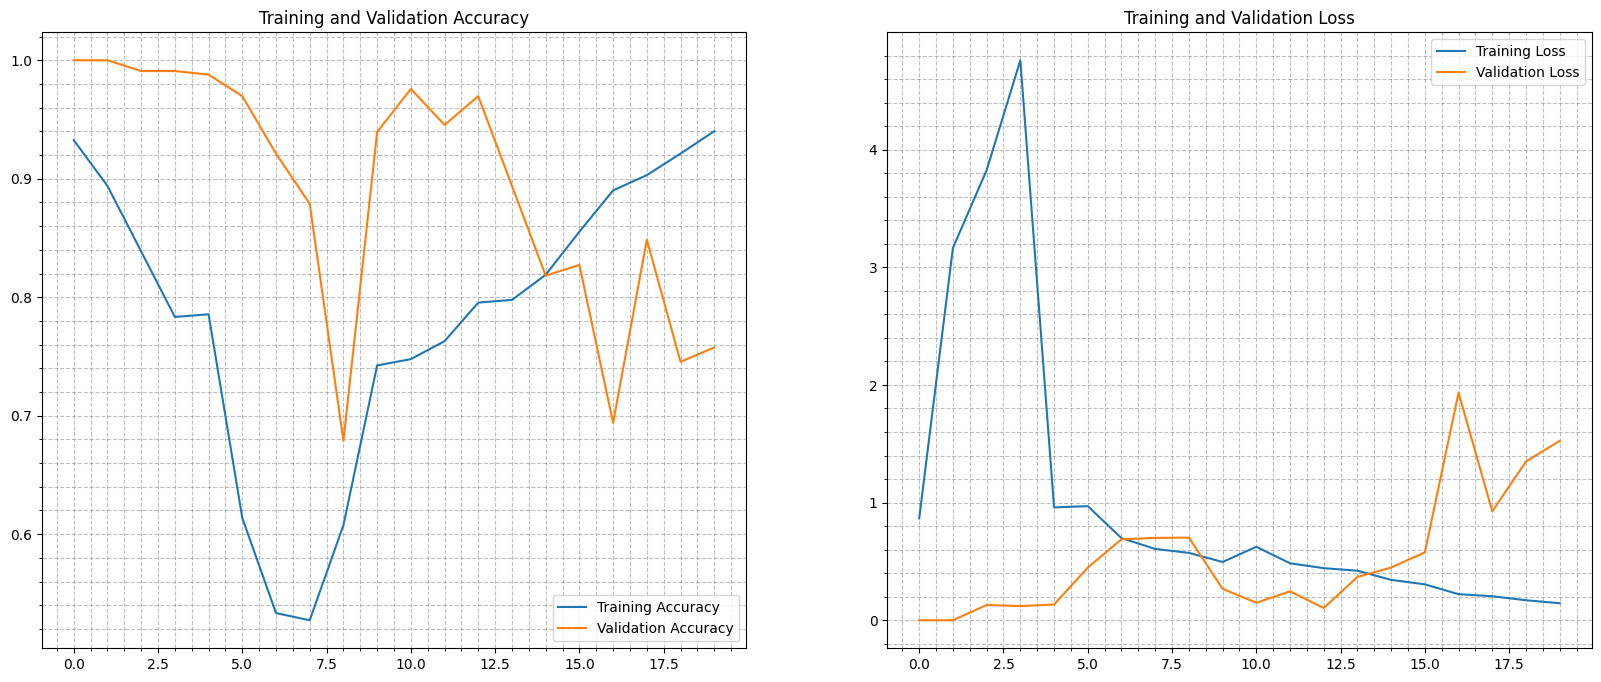

In [47]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

fig = plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
# add grid
ax = fig.gca()
ax.xaxis.set_minor_locator(AutoMinorLocator(5))
ax.yaxis.set_minor_locator(AutoMinorLocator(5))
ax.grid(color='gray', linestyle='--', which="both", alpha=0.5)
# plt.grid(color='gray', linestyle='--', which="both")  # Specify grid with line attributes
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
# add grid
ax = fig.gca()
ax.xaxis.set_minor_locator(AutoMinorLocator(5))
ax.yaxis.set_minor_locator(AutoMinorLocator(5))
ax.grid(color='gray', linestyle='--', which="both", alpha=0.5)
# plt.grid(color='gray', linestyle='--')  # Specify grid with line attributes
plt.savefig("Training and Validation Accuracy and Loss.png", dpi=150)

plt.show()

# Select best model

#### Let's decide that the best model should have next values:
loss <= 0.4
accuracy >= 0.75
val_loss <= 0.4
val_accuracy >= 0.75

In [48]:
_best_models = []
for d in list_for_models:
    model = d['model']
    loss = d['loss']
    accuracy = d['accuracy']
    val_loss = d['val_loss']
    val_accuracy = d['val_accuracy']
    print(model, loss, accuracy, val_loss, val_accuracy)
    if loss <= 0.45 and accuracy >= 0.75 and val_loss <= 0.45 and val_accuracy >= 0.75:
        _best_models.append(d)

<keras.src.engine.sequential.Sequential object at 0x7fbe56e34580> 0.8661091923713684 0.9325757622718811 0.0 1.0
<keras.src.engine.sequential.Sequential object at 0x7fbe56e34580> 3.1645140647888184 0.8939393758773804 0.00020620827854145318 1.0
<keras.src.engine.sequential.Sequential object at 0x7fbe56e34580> 3.825221538543701 0.8386363387107849 0.12990130484104156 0.9909090995788574
<keras.src.engine.sequential.Sequential object at 0x7fbe56e34580> 4.759599685668945 0.7833333611488342 0.12110330164432526 0.9909090995788574
<keras.src.engine.sequential.Sequential object at 0x7fbe56e34580> 0.9594049453735352 0.7856060862541199 0.13382460176944733 0.9878787994384766
<keras.src.engine.sequential.Sequential object at 0x7fbe56e34580> 0.9701591730117798 0.6136363744735718 0.4479095935821533 0.9696969985961914
<keras.src.engine.sequential.Sequential object at 0x7fbe56e34580> 0.6981938481330872 0.5333333611488342 0.6882309317588806 0.9212121367454529
<keras.src.engine.sequential.Sequential object

In [49]:
_best_models

[{'model': <keras.src.engine.sequential.Sequential at 0x7fbe56e34580>,
  'loss': 0.44291722774505615,
  'accuracy': 0.7954545617103577,
  'val_loss': 0.10428262501955032,
  'val_accuracy': 0.9696969985961914},
 {'model': <keras.src.engine.sequential.Sequential at 0x7fbe56e34580>,
  'loss': 0.4212797284126282,
  'accuracy': 0.7977272868156433,
  'val_loss': 0.36857476830482483,
  'val_accuracy': 0.8939393758773804},
 {'model': <keras.src.engine.sequential.Sequential at 0x7fbe56e34580>,
  'loss': 0.34348687529563904,
  'accuracy': 0.8189393877983093,
  'val_loss': 0.44799426198005676,
  'val_accuracy': 0.8181818127632141}]

In [50]:
if not len(_best_models):
    call_not_exist_function_to_prevent_code_run_as_we_dont_have_best_model  # exit, if no best models

# Save best model

In [51]:
# let's take first model
_best_models[0]["model"].save('best_model.keras')

# Check model

In [52]:
# let's load our model from disk
loaded_model = load_model('best_model.keras')
# checking its architecture
loaded_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 128, 128, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 63, 63, 32)        0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 63, 63, 32)        128       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 30, 30, 32)        0

# Save model to dataset

#### This model will be accesible in this dataset: [Trading robot 📈 based on computer vision Models](https://www.kaggle.com/datasets/olegshpagin/trading-robot-based-on-computer-vision-models)

# Check predictions

In [53]:
# 1) will check it on val data
_predict = model.predict(val_ds, verbose=1)

33/33 [==============================] - 1s 26ms/step


In [54]:
_predict

array([[-3.32842040e+00, -1.10453105e+00],
       [-1.20363426e+00,  3.62029338e+00],
       [-5.32032728e+00,  2.87484336e+00],
       [-1.77623105e+00, -1.29045069e+00],
       [-2.74716043e+00, -2.15578270e+00],
       [-6.45996332e+00,  3.65039754e+00],
       [-6.05426788e+00, -1.72476578e+00],
       [-2.77266693e+00, -2.68851209e+00],
       [-6.62221098e+00, -7.85765767e-01],
       [-5.37929344e+00, -3.36633182e+00],
       [-2.62913251e+00,  6.09006174e-02],
       [-2.67309809e+00,  6.31282032e-01],
       [ 1.26336265e+00,  7.52040863e+00],
       [-1.13860393e+00,  2.03637886e+00],
       [ 7.01504052e-01,  7.86856413e-01],
       [ 3.72382474e+00,  8.68020594e-01],
       [-3.44547200e+00,  1.49951661e+00],
       [ 3.83155644e-01,  1.81477356e+00],
       [-8.93921375e+00, -3.63499403e+00],
       [ 6.59546405e-02,  2.77232885e-01],
       [-4.94969904e-01,  1.85534227e+00],
       [-3.33258653e+00,  5.39652407e-01],
       [-6.54036283e+00, -2.07018808e-01],
       [-5.

# To be continued

#### P.S. This notebook in a process of creating, please be patient. Thanks.

#### Feel free to leave comment. Thanks.

# Thanks

## If you liked this - then say about it)) **⬆️** or **comment** or 🌟

# Continue

## Next version is in new file
## +Fix for Training and Validation sets where in Validation set we will have both classes